# Description

This includes the experiments for the theoretical formulation chapter of the thesis.

## Example of the combined potential

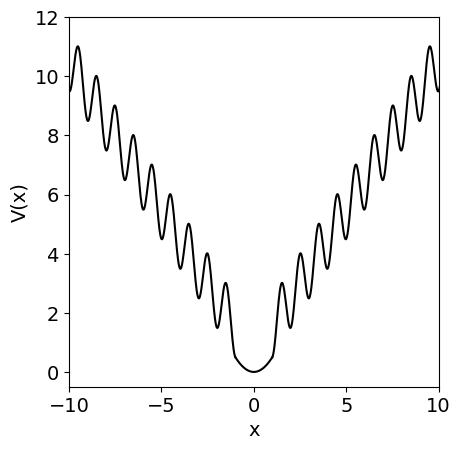

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from multifractal_gd.general_tools import squarify

BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

##### Potential #####
V0 = 1
x0 = 1
F = 1
x1 = np.linspace(-20, -1, 1000)
x2 = np.linspace(-1, 1, 1000)
x3 = np.linspace(1, 20, 1000)
y1 = -V0 * np.cos(2*np.pi*x1/x0) - F*x1 + 0.5
y2 = x2**2/2
y3 = -V0 * np.cos(2*np.pi*x3/x0) + F*x3 + 0.5

##### Plot #####
fig, ax = plt.subplots()
ax.plot(x1, y1, 'k-', x2, y2, 'k-', x3, y3, 'k-')
ax.set_xlim([-10, 10])
ax.set_ylim([-0.5, 12])
ax.set_xlabel('x')
ax.set_ylabel('V(x)')
squarify(fig)
fig.savefig("figures/combined_potential.pdf", dpi=600, bbox_inches='tight')
plt.show()

## Example of integrating FLE
An illustrative example of how to integrate the FLE. I encourage playing with the parameters to get an intuition. Note the data for plotting the figure in the thesis has been saved from a prior simulation, and loaded for plotting.

In [ ]:
import random 
import numpy as np
from scipy.special import gamma
from fbm import FBM
from multifractal_gd.fle_tools import find_a, find_b, find_RHS_combined

random.seed(0)
np.random.seed(0)

##### Parameters #####
# Parameters
H = 0.6 # Holder exponent
xi = -50 # starting point
lr = 1 # learning rate of GD
f_coeff = 1 # generalised friction coefficient
sharpness = 1 # sharpness of harmonic potential
L = 10 # extent of harmonic potential
V0 = 0.2 # amplitude of tilted washboard
x0 = 1 # period of tilted washboard
F = 0.1 # bias of tilted washboard

# Parameters for integration; see Ashford-Bashford-Moulton method referenced in thesis
t = 0
k = 0
h = 1
T = 2000

##### Simulation #####
# Derived parameters; not user choice
alpha = 2 - 2*H
n = np.ceil(alpha)
c1 = 1/gamma(alpha)

# FGN
kmax = T // h
f = FBM(1 << (kmax-1).bit_length(), H)
fgn = f.fgn()

# Track predictor, corrector, positions, times
predictor = 0
corrector = xi
pos = [xi]
times = [0]

# Simulation
while t < T:
    # Predictor
    predictor = pos[0]
    j = 0
    s1_tmp = 0
    while j <= k:
        s1_tmp += find_b(h, j, k, alpha) * \
            find_RHS_combined(pos[j], lr, sharpness, L, f_coeff, V0, x0, F, H, fgn[j])
        j += 1
    predictor += s1_tmp/gamma(alpha)
    # Corrector
    corrector = pos[0]
    j = 0
    s2_tmp = 0
    while j <= k:
        s2_tmp += find_a(h, j, k, alpha) * \
            find_RHS_combined(pos[j], lr, sharpness, L, f_coeff, V0, x0, F, H, fgn[j])
        j += 1

    corrector += (s2_tmp + find_a(h, k+1, k, alpha) * find_RHS_combined(predictor, lr, sharpness, L, f_coeff, V0, x0, F, H, fgn[j]))/gamma(alpha)
    k += 1
    t += h
    pos.append(corrector)
    times.append(t)
    print("Completed: " + str(t/T * 100) + "%")
    
# One can then use the positions recorded for analysis, e.g., below
# Note that the main point of this is to demonstrate the existence of transient super-diffusion

## Plot transient superdiffusion

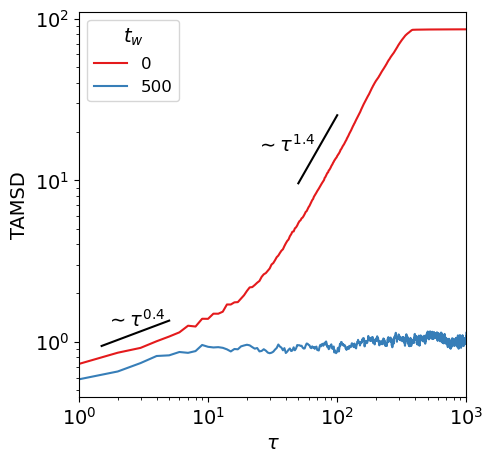

In [3]:
import numpy as np
from scipy.io import loadmat
from multifractal_gd.general_tools import squarify
import matplotlib.pyplot as plt

BIGGER_SIZE = 14
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

data = loadmat("data/theory/FLE_example.mat")
x = data["x"]
y = data["y"]
fig, ax = plt.subplots(figsize=(5,5))
ax.loglog(x[0,:], y[0,:], c='#e41a1c', label='0')
ax.loglog(x[1,:], y[1,:], c='#377eb8', label='500')
# Eye guides
X = np.array([1.5,5])
Y = X**0.3 / 1.2
ax.plot(X,Y, 'k')
fig.text(0.18, 0.25, r'$\sim \tau^{0.4}$')
X = np.array([50,100])
Y = X**1.4 / 25
ax.plot(X,Y, 'k')
fig.text(0.48, 0.6, r'$\sim \tau^{1.4}$')
# Appearance
ax.set_xlim([1,1000])
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('TAMSD')
legend = ax.legend(title=r"$t_w$")
fig.savefig("figures/transient_superdiffusion_FLE.pdf", dpi=600, bbox_inches='tight', format='pdf')
plt.show()

## Plot multiple sub-diffusion with fit

Fitting by eye the theoretical TAMSD to experimental curves. This can be done by maximum likelihood also, but this is a sufficient demonstration.

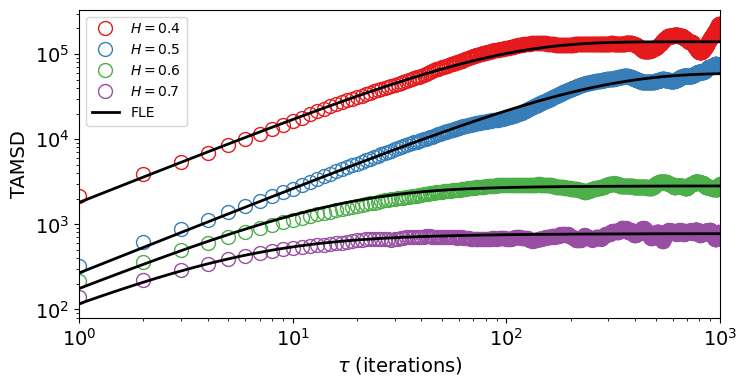

In [5]:
import multifractal_gd.general_tools as general_tools
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np

BIGGER_SIZE = 14
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# All on one figure
plt.rc('legend', fontsize=10)    # legend fontsize
fig, ax = plt.subplots(figsize=(8.27,4))

# H = 0.4
scaling = 8
tamsd_data = loadmat("data/fractional_brownian_surfaces/H=0.4/TAMSD_H=0.4.mat")
xs = tamsd_data["xs"]
ys = tamsd_data["ys"]
line = 3
limiting_var = np.mean(ys[line,100:]) / 2
C = 0.013
H = 0.5
a = 2-2*H
tau = np.logspace(0, 3, 100)
msd1 = []
for t in tau:
    msd1.append( 1 - general_tools.mittag_leffler(-C*t, a) )
msd1 = np.array(msd1) * 2 * limiting_var
ax.loglog(xs[line],ys[line]*scaling, 'o', color='#e41a1c', markerfacecolor='none', markersize=10, label=r'$H=0.4$')
ax.loglog(tau, msd1*scaling, 'k', linewidth=2)

# H = 0.5
scaling = 1
tamsd_data = loadmat("data/fractional_brownian_surfaces/H=0.5/TAMSD_H=0.5.mat")
xs = tamsd_data["xs"]
ys = tamsd_data["ys"]
line = 2
limiting_var = np.mean(ys[line,500:]) / 2
C = 0.0045
H = 0.5
a = 2-2*H
tau = np.logspace(0, 3, 100)
msd1 = []
for t in tau:
    msd1.append( 1 - general_tools.mittag_leffler(-C*t, a) )
msd1 = np.array(msd1) * 2 * limiting_var
ax.loglog(xs[line],ys[line]*scaling, 'o', color='#377eb8', markerfacecolor='none', markersize=10, label=r'$H=0.5$')
ax.loglog(tau, msd1*scaling, 'k', linewidth=2)

# H = 0.6
scaling = 1
tamsd_data = loadmat("data/fractional_brownian_surfaces/H=0.6/TAMSD_H=0.6.mat")
xs = tamsd_data["xs"]
ys = tamsd_data["ys"]
limiting_var = np.mean(ys[-1,100:]) / 2
C = 0.06
H = 0.6
a = 2-2*H
tau = np.logspace(0, 3, 100)
msd = []
for t in tau:
    msd.append( 1 - general_tools.mittag_leffler(-C*t, a) )
msd = np.array(msd) * 2 * limiting_var
ax.loglog(xs[-1],ys[-1]*scaling, 'o', color='#4daf4a', markerfacecolor='none', markersize=10, label=r'$H=0.6$')
ax.loglog(tau, msd*scaling, 'k', linewidth=2)

# H = 0.7
scaling = 0.3
tamsd_data = loadmat("data/fractional_brownian_surfaces/H=0.7/TAMSD_H=0.7.mat")
xs = tamsd_data["xs"]
ys = tamsd_data["ys"]
limiting_var = np.mean(ys[-1,100:]) / 2
C = 0.15
H = 0.7
a = 2-2*H
tau = np.logspace(0, 3, 100)
msd = []
for t in tau:
    msd.append( 1 - general_tools.mittag_leffler(-C*t, a) )
msd = np.array(msd) * 2 * limiting_var
ax.loglog(xs[-1],ys[-1]*scaling, 'o', color='#984ea3', markerfacecolor='none', markersize=10, label=r'$H=0.7$')
ax.loglog(tau, msd*scaling, 'k', linewidth=2, label='FLE')


ax.set_xlim([1,1000])
ax.set_ylabel("TAMSD")
ax.set_xlabel(r"$\tau$ (iterations)")
ax.legend()
fig.savefig("figures/subdiffusion_FLE.pdf", dpi=600, bbox_inches='tight')
plt.show()

## Power spectral density

The first second of the code below gives illustrative examples of how to calculate the power law exponent. The second part plots the saved results that include these examples as well as others.

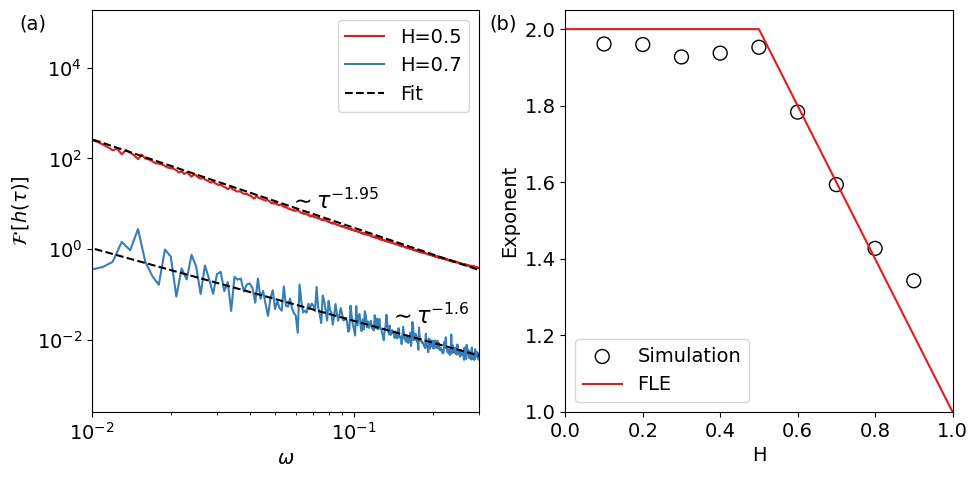

In [8]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

BIGGER_SIZE = 14
SMALLER_SIZE = 12
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax1, ax2 = ax

##### Particular examples #####
# Particular example H = 0.5
trajectory = loadmat("data/fractional_brownian_surfaces/H=0.5/asymptotic.mat")["trajectory"]
# 1st PC direction
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(trajectory)
x = principalComponents[:,0].flatten()
result = np.correlate(x,x,mode='full')
autocorr1 = result[result.size//2:]

data = autocorr1/np.max(autocorr1)
ps1 = np.abs(np.fft.fft(data))**2
time_step = 1
freqs1 = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs1)

xdata1 = freqs1[idx]
xdata1 = xdata1[len(xdata1)//2 + 1:]
ydata1 = ps1[idx]
ydata1 = ydata1[len(ydata1)//2 + 1:]

# Particular example H = 0.7
trajectory = loadmat("data/fractional_brownian_surfaces/H=0.7/asymptotic.mat")["trajectory"][:1000,:]
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(trajectory)
x = principalComponents[:,0].flatten()
result = np.correlate(x,x,mode='full')
autocorr2 = result[result.size//2:]

data = autocorr2/np.max(autocorr2)
ps2 = np.abs(np.fft.fft(data))**2
time_step = 1
freqs2 = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs2)

xdata2 = freqs2[idx]
xdata2 = xdata2[len(xdata2)//2 + 1:]
ydata2 = ps2[idx]
ydata2 = ydata2[len(ydata2)//2 + 1:]
ydata2 /= 100 # For aesthetics

ax1.loglog(xdata1, ydata1, '-', color='#e41a1c', markerfacecolor='none', markersize=5, label='H=0.5')
ax1.loglog(xdata2, ydata2, '-', color='#377eb8', markerfacecolor='none', markersize=5, label='H=0.7')
# Fits 
xfit1 = np.array([1e-3,1e0])
yfit1 = xfit1**-1.95 / 30
ax1.loglog(xfit1,yfit1,'k--',label='Fit')
fig.text(0.3, 0.56, r'$\sim \tau^{-1.95}$', fontsize=16)

xfit2 = np.array([1e-3,1e0])
yfit2 = xfit2**-1.6 / 1500
ax1.loglog(xfit2,yfit2,'k--')
fig.text(0.4, 0.33, r'$\sim \tau^{-1.6}$', fontsize=16)

# Appearance
ax1.set_xlim([1e-2,3e-1])
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$\mathcal{F}\,[h(\tau)]$')
ax1.legend()

##### Overall #####

exponents = loadmat("data/fractional_brownian_surfaces/psd.mat")["exponents"]
H = np.arange(0.1,1,0.1)
th_H = np.arange(0,1.1,0.1)
th_asymptotic_exp = 2*th_H - 3
th_asymptotic_exp[:6] = -2

ax2.scatter(H,np.abs(exponents.flatten()), marker='o', facecolors='none', edgecolors='k', s=100, label='Simulation')
ax2.plot(th_H,np.abs(th_asymptotic_exp), label='FLE', c='#e41a1c')
ax2.set_xlim([0,1])
ax2.set_ylim(ymin=1)
ax2.set_xlabel('H')
ax2.set_ylabel('Exponent')
ax2.legend(loc=3)


# Apperance
fig.subplots_adjust(wspace=-0.3, hspace=0)

# Subplot labels
fig.text(0.03, 0.92, '(a)')
fig.text(0.50, 0.92, '(b)')

fig.tight_layout()
fig.savefig("figures/PSD.pdf", dpi=1200, bbox_inches='tight')
plt.show()

# Max Hessian eigenvalue

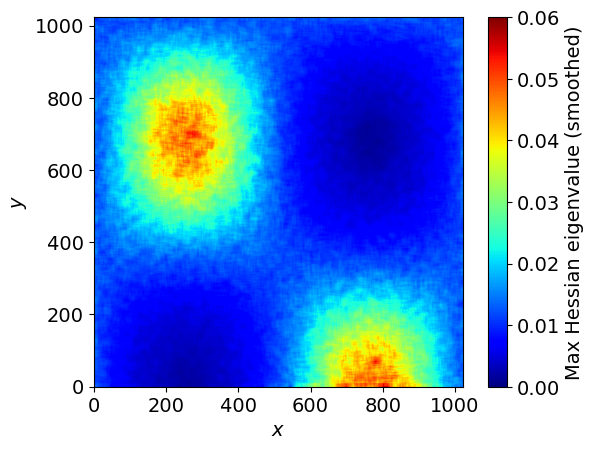

(-0.936753934935087, 0.0)


In [3]:
import numpy as np
from scipy.io import loadmat, savemat
from scipy.ndimage.filters import uniform_filter
from scipy.stats.stats import pearsonr   
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from multifractal_gd.hessian_tools import hessian, diagonalise_hessian

BIGGER_SIZE = 14
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

##### Smoothed maximum Hessian eigenvalue #####
# Max eigenvalues
landscape = loadmat("data/multifractional_brownian_surface/landscape.mat")["landscape"] # load landscape
hess = hessian(landscape) # calculate hessian at each point
eigenvalues = diagonalise_hessian(hess) # Calculate eigenvalues at each point
max_eig = np.squeeze(eigenvalues[:,1,:,:])

# Maximum eigenvalue over landscape 
max_eig = np.squeeze(eigenvalues[:,1,:,:])
max_eig = uniform_filter(input=max_eig, size=20)

plt.imshow(max_eig, cmap=cm.jet, origin='lower', vmin=0, vmax=0.06)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
cb = plt.colorbar()
cb.set_label('Max Hessian eigenvalue (smoothed)')
plt.savefig("figures/hessian_model.pdf", dpi=600, bbox_inches='tight')
plt.show()

##### Correlation coefficient #####
max_eig = max_eig.flatten()
# Holder exponent
L = 1024
x = np.arange(0,1024)
y = np.arange(0,1024)
xx, yy = np.meshgrid(x,y)
H = 0.5 + 0.2 * np.sin(2*np.pi*xx/L) * np.cos(3*np.pi*yy/(2*L))
H = H.flatten()
print(pearsonr(H,max_eig))